In [5]:
!pip install -q torch_snippets
from torch_snippets import *
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*')
        self.transform = transform
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*', silent=True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)


In [7]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

In [8]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [11]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [12]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [13]:
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)
    if epoch==10: optimizer = optim.Adam(model.parameters(), lr=0.0005)

EPOCH: 20.000  trn_acc: 0.660  val_loss: 0.404  trn_loss: 0.569  val_acc: 0.767  (33.49s - 301.37s remaining)
EPOCH: 40.000  trn_acc: 0.734  val_loss: 0.242  trn_loss: 0.412  val_acc: 0.867  (52.68s - 210.70s remaining)
EPOCH: 60.000  trn_acc: 0.789  val_loss: 0.142  trn_loss: 0.326  val_acc: 0.933  (72.45s - 169.05s remaining)
EPOCH: 80.000  trn_acc: 0.861  val_loss: 0.188  trn_loss: 0.287  val_acc: 0.867  (91.39s - 137.08s remaining)
EPOCH: 100.000  trn_acc: 0.827  val_loss: 0.210  trn_loss: 0.281  val_acc: 0.833  (112.41s - 112.41s remaining)
EPOCH: 120.000  trn_acc: 0.862  val_loss: 0.267  trn_loss: 0.258  val_acc: 0.833  (131.66s - 87.78s remaining)
EPOCH: 140.000  trn_acc: 0.875  val_loss: 0.143  trn_loss: 0.216  val_acc: 0.933  (150.89s - 64.67s remaining)
EPOCH: 160.000  trn_acc: 0.885  val_loss: 0.284  trn_loss: 0.200  val_acc: 0.767  (170.01s - 42.50s remaining)
EPOCH: 180.000  trn_acc: 0.918  val_loss: 0.105  trn_loss: 0.191  val_acc: 0.867  (189.17s - 21.02s remaining)
EPOC

100%|██████████| 301/301 [00:00<00:00, 2464.22it/s]


[07/28/23 08:20:44] INFO     metric val_loss was not fully recorded. ]8;id=125632;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=864517;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             Plotting final epochs using last                                       
                             recorded value                                                         

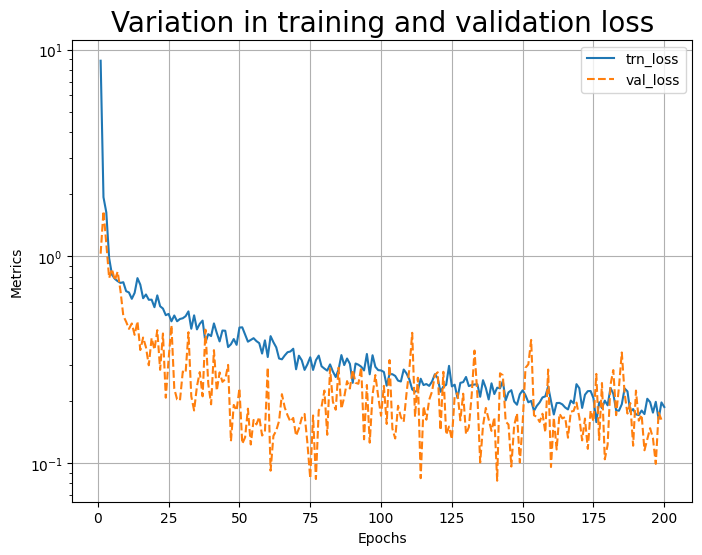

100%|██████████| 301/301 [00:00<00:00, 2639.98it/s]


[07/28/23 08:20:45] INFO     metric val_acc was not fully recorded.  ]8;id=57124;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=254744;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             Plotting final epochs using last                                       
                             recorded value                                                         

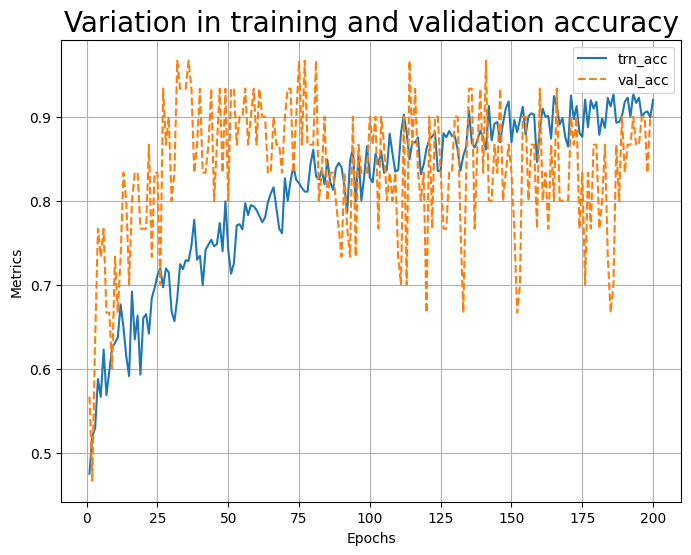

In [14]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

In [15]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1922,  ..., 0.5804, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1843,  ..., 0.4314, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1922,  ..., 0.5804, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1843,  ..., 0.4314, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1922,  ..., 0.5804, 0.0000, 0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1922,  ..., 0.4824, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1843,  ..., 0.2039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1922,  ..., 0.4824, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1843,  ..., 0.2039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1922,  ..., 0.4824, 0.0000, 0.